## Training & loading larger networks

Written by KN, Feb-2017

Based on: https://github.com/pkmital/CADL/blob/master/session-4/lecture-4.ipynb

In [26]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython.display as ipyd
#from libs import gif, nb_utils
import os
from six.moves import urllib
import zipfile
from tensorflow.python.platform import gfile
from IPython.display import display, HTML
from skimage.transform import resize as imresize

In [3]:
sess = tf.InteractiveSession()

In [14]:
# Functions to load inception model

def download(path):
    """Use urllib to download a file.
    Parameters
    ----------
    path : str
        Url to download
    Returns
    -------
    path : str
        Location of downloaded file.
    """
    fname = path.split('/')[-1]
    if os.path.exists(fname):
        return fname

    print('Downloading ' + path)

    def progress(count, block_size, total_size):
        if count % 20 == 0:
            print('Downloaded %02.02f/%02.02f MB' % (
                count * block_size / 1024.0 / 1024.0,
                total_size / 1024.0 / 1024.0))

    filepath, _ = urllib.request.urlretrieve(path, filename=fname, reporthook=progress)
    return filepath

def download_and_extract_zip(path, dst):
    """Download and extract a zip file.
    Parameters
    ----------
    path : str
        Url to zip file to download.
    dst : str
        Location to save zip file contents.
    """
    filepath = download(path)
    if not os.path.exists(dst):
        os.makedirs(dst)
        zf = zipfile.ZipFile(file=filepath)
        zf.extractall(dst)
        

def inception_download(data_dir='inception', version='v5'):
    """Download a pretrained inception network.
    Parameters
    ----------
    data_dir : str, optional
        Location of the pretrained inception network download.
    version : str, optional
        Version of the model: ['v3'] or 'v5'.
    """
    if version == 'v3':
        download_and_extract_tar(
            'https://s3.amazonaws.com/cadl/models/inception-2015-12-05.tgz', data_dir)
        return (os.path.join(data_dir, 'classify_image_graph_def.pb'),
                os.path.join(data_dir, 'imagenet_synset_to_human_label_map.txt'))
    else:
        download_and_extract_zip(
            'https://s3.amazonaws.com/cadl/models/inception5h.zip', data_dir)
        return (os.path.join(data_dir, 'tensorflow_inception_graph.pb'),
                os.path.join(data_dir, 'imagenet_comp_graph_label_strings.txt'))

    
def get_inception_model(data_dir='inception', version='v5'):
    """Get a pretrained inception network.
    Parameters
    ----------
    data_dir : str, optional
        Location of the pretrained inception network download.
    version : str, optional
        Version of the model: ['v3'] or 'v5'.
    Returns
    -------
    net : dict
        {'graph_def': graph_def, 'labels': synsets}
        where the graph_def is a tf.GraphDef and the synsets
        map an integer label from 0-1000 to a list of names
    """
    # Download the trained net
    model, labels = inception_download(data_dir, version)

    # Parse the ids and synsets
    txt = open(labels).readlines()
    synsets = [(key, val.strip()) for key, val in enumerate(txt)]

    # Load the saved graph
    with gfile.GFile(model, 'rb') as f:
        graph_def = tf.GraphDef()
        try:
            graph_def.ParseFromString(f.read())
        except:
            print('try adding PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python' +
                  'to environment.  e.g.:\n' +
                  'PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python ipython\n' +
                  'See here for info: ' +
                  'https://github.com/tensorflow/tensorflow/issues/582')
    return {
        'graph_def': graph_def,
        'labels': synsets,
    }

In [15]:
# load up pre-trained network
net = get_inception_model()   # returns a dictionary with 'graph_def' and 'labels'

In [19]:
# put into TF
tf.import_graph_def(net['graph_def'], name='inception')

In [20]:
# to look at what's inside
g = tf.get_default_graph()
names = [op.name for op in g.get_operations()]
print(names)

[u'inception/input', u'inception/conv2d0_w', u'inception/conv2d0_b', u'inception/conv2d1_w', u'inception/conv2d1_b', u'inception/conv2d2_w', u'inception/conv2d2_b', u'inception/mixed3a_1x1_w', u'inception/mixed3a_1x1_b', u'inception/mixed3a_3x3_bottleneck_w', u'inception/mixed3a_3x3_bottleneck_b', u'inception/mixed3a_3x3_w', u'inception/mixed3a_3x3_b', u'inception/mixed3a_5x5_bottleneck_w', u'inception/mixed3a_5x5_bottleneck_b', u'inception/mixed3a_5x5_w', u'inception/mixed3a_5x5_b', u'inception/mixed3a_pool_reduce_w', u'inception/mixed3a_pool_reduce_b', u'inception/mixed3b_1x1_w', u'inception/mixed3b_1x1_b', u'inception/mixed3b_3x3_bottleneck_w', u'inception/mixed3b_3x3_bottleneck_b', u'inception/mixed3b_3x3_w', u'inception/mixed3b_3x3_b', u'inception/mixed3b_5x5_bottleneck_w', u'inception/mixed3b_5x5_bottleneck_b', u'inception/mixed3b_5x5_w', u'inception/mixed3b_5x5_b', u'inception/mixed3b_pool_reduce_w', u'inception/mixed3b_pool_reduce_b', u'inception/mixed4a_1x1_w', u'inception/mix

In [21]:
names[0]

u'inception/input'

In [22]:
input_name = names[0] + ':0'
x = g.get_tensor_by_name(input_name)

In [24]:
softmax = g.get_tensor_by_name(names[-1] + ':0')

## Try predicting with loaded network

In [56]:
from skimage.data import coffee
og = coffee()
plt.imshow(og)
print(og.min(), og.max())
pre_maxIm = og.max()

(0, 255)


In [58]:
# Preprocessing fxn

def preprocess(img, crop=True, resize=True, dsize=(299, 299), imnet_mean = 117):
    if img.dtype != np.uint8:
        img *= 255.0

    if crop:
        crop = np.min(img.shape[:2])
        r = (img.shape[0] - crop) // 2
        c = (img.shape[1] - crop) // 2
        cropped = img[r: r + crop, c: c + crop]
    else:
        cropped = img

    if resize:
        rsz = imresize(cropped, dsize)
        rsz = rsz*img.max()
    else:
        rsz = cropped

    if rsz.ndim == 2:
        rsz = rsz[..., np.newaxis]

    rsz = rsz.astype(np.float32)
    # subtract imagenet mean
    return (rsz - imnet_mean)

In [48]:
imresize?

(400, 600, 3)
(299, 299, 3)


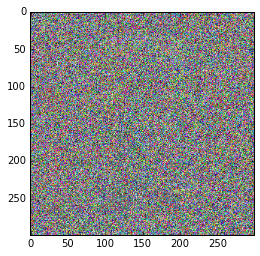

In [59]:
img = preprocess(og)
print(og.shape)
print(img.shape)
plt.imshow(img)
#img=img*pre_maxIm
#plt.imshow(img)

In [60]:
# add first dimension
img_4d = img[np.newaxis]
print(img_4d.shape)

(1, 299, 299, 3)


In [61]:
print(img.min(), img.max())

(-117.0, 138.0)


In [62]:
# See what the prediction is for this label
res = np.squeeze(softmax.eval(feed_dict={x: img_4d}))

# normalize
res = np.mean(res, 0)
res = res / np.sum(res)
print(np.shape(res))
print(res)

(1008,)
[  3.95740501e-14   2.34581566e-16   7.38100640e-12 ...,   3.95713363e-14
   3.95760898e-14   3.95741247e-14]


In [63]:
# Look at predicted labels
numTop = 10
top_predLabel_ind = res.argsort()[-numTop:][::-1]
print([(res[idx], net['labels'][idx]) for idx in top_predLabel_ind])

[(0.99849206, (947, 'espresso')), (0.000631253, (859, 'cup')), (0.00050241494, (953, 'chocolate sauce')), (0.00019483207, (844, 'consomme')), (0.00013370356, (822, 'soup bowl')), (2.2646056e-05, (996, 'coffee mug')), (1.0453795e-05, (823, 'eggnog')), (2.8054892e-06, (514, 'strainer')), (2.4793335e-06, (798, 'red wine')), (2.4155261e-06, (892, 'ladle'))]


## Visualizing the filters inside now

### Just looking at first set of filters' weights

In [64]:
# Get first filter
W = g.get_tensor_by_name('inception/conv2d0_w:0')
W_eval = W.eval()
print(W_eval.shape)

(7, 7, 3, 64)


In [74]:
plt.pcolormesh?

In [75]:
#### TODO  [!!!!!!]
# Need to look at montage function

def montage_filters(W):
    """ Plots all filters; image in format e.g., [150,150,1,64]"""
    maxW = np.max(W)
    minW = np.min(W)
    W = np.reshape(W, [W.shape[0], W.shape[1], 1, W.shape[2] * W.shape[3]])  # reshapes into collapsing of all channels & filters
    nRows = np.ceil(np.sqrt(W.shape[-1]))
    for i in range(W.shape[-1]):
        plt.subplot(nRows, nRows, i+1)
        plt.pcolormesh(W[:,:,0,i], cmap='Greys', vmin=minW, vmax=maxW)
    plt.tight_layout()
    

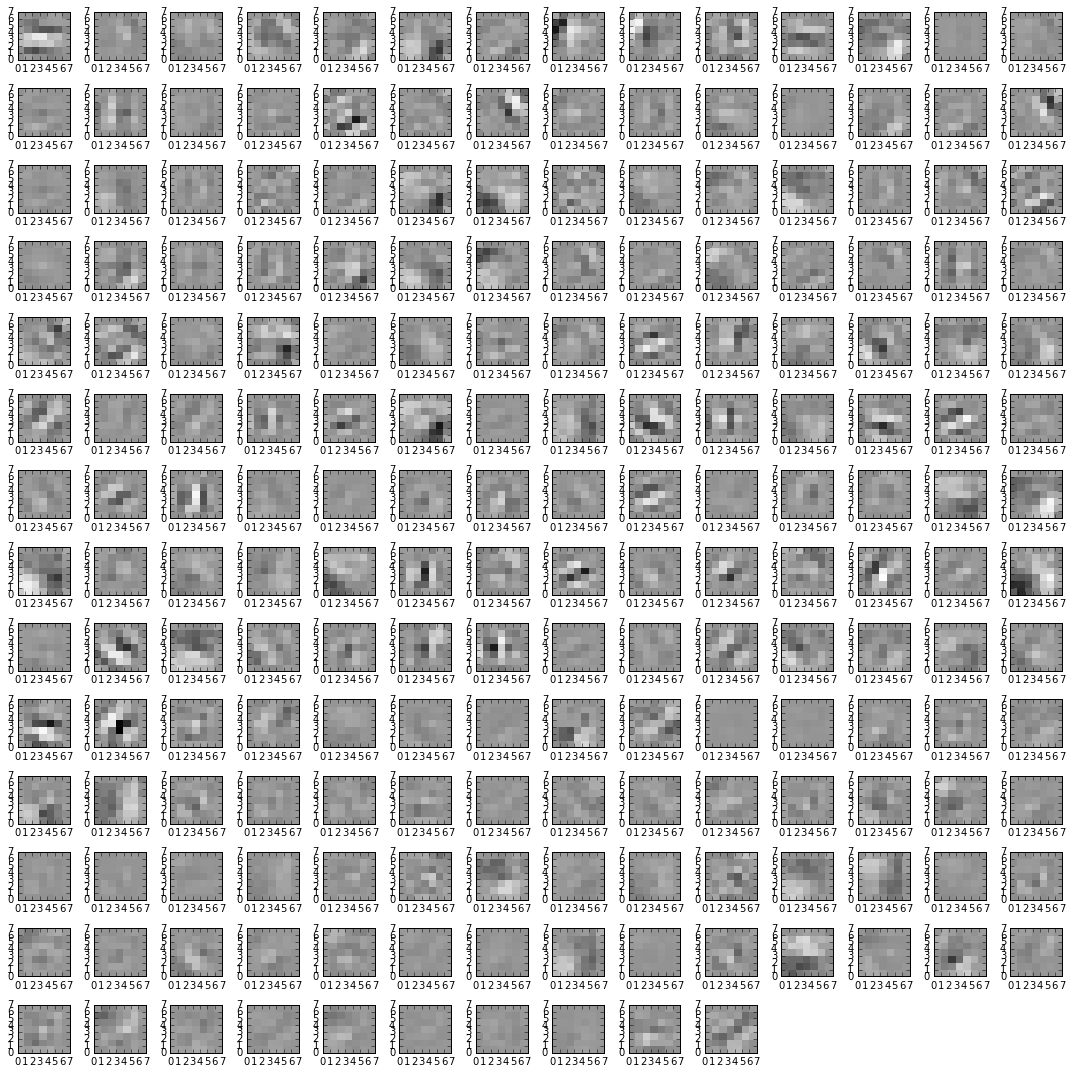

In [76]:
plt.figure(figsize=(15,15))
montage_filters(W_eval)

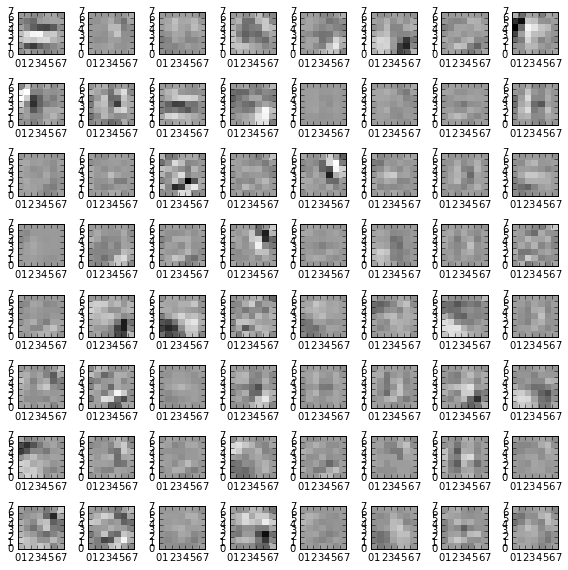

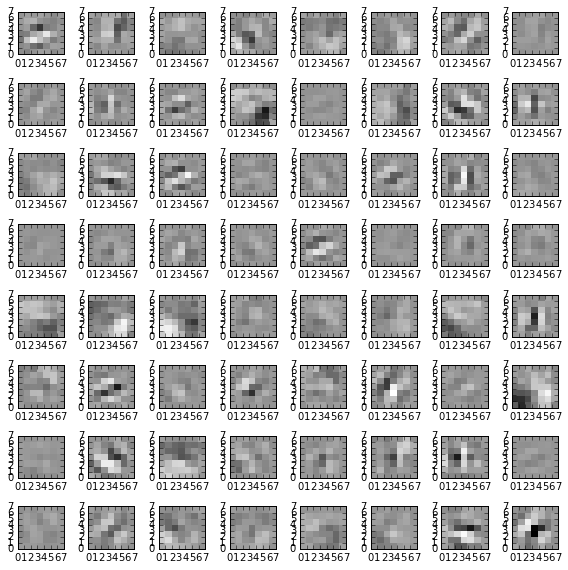

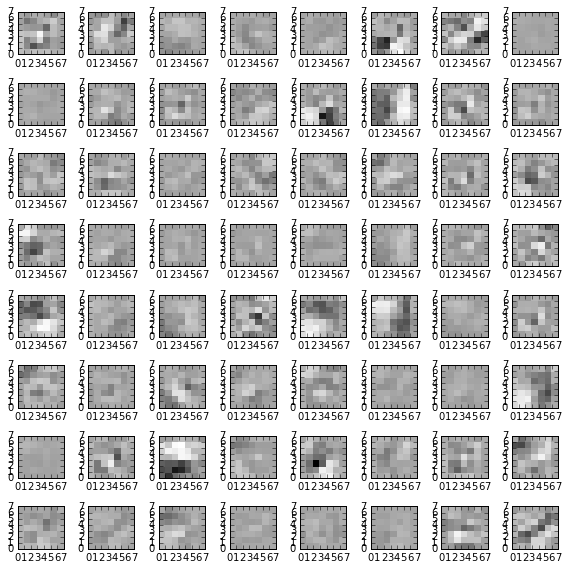

In [80]:
# Look at influence of each color channel
numChannels = 3
#Ws_byChannel = [montage_filters(W_eval[:, :, [i], :]) for i in range(numChannels)]
#print(np.shape(np.array(Ws_byChannel)))
#Ws_byChannel = np.rollaxis(np.array(Ws_byChannel), 0, 3)   # this fxn rolls axis 0 until just before axis 3
# [Not sure why....?]  [TODO !!!] 
#plt.figure(figsize=(10,10))
#plt.imshow(Ws_byChannel, interpolation='nearest')

for i in range(numChannels):
    plt.figure(figsize=[8,8])
    montage_filters(W_eval[:,:,[i],:])


In [66]:
np.rollaxis?

In [ ]:
# Can see more easily what is going on if normalize filters
# [TODO!!! - why add this term?]
# Not doing this b/c doing some addition of the colors or something - figure out later 
multTerm = 128
sumTerm = 128
print(np.min(Ws_byChannel)) 
print(np.max(Ws_byChannel))
Ws_byChannel_norm = (Ws_byChannel / np.max(np.abs(Ws_byChannel)) * multTerm + sumTerm).astype(np.uint8)

# Plot
plt.figure(figsize=(10,10))
plt.imshow(Ws_byChannel_norm, interpolation='nearest')

### Now, look at what happens when convolve filter with image

In [83]:
# Now, look at what happens when convolve filters with image
feature = g.get_tensor_by_name('inception/conv2d0_pre_relu:0')

layer_shape = tf.shape(feature).eval(feed_dict={x:img_4d})
print(layer_shape)

[  1 150 150  64]


In [82]:
tf.shape(feature)

<tf.Tensor 'Shape:0' shape=(4,) dtype=int32>

In [90]:
f = feature.eval(feed_dict={x: img_4d})
#montage = utils.montage_filters(np.rollaxis(np.expand_dims(f[0], 3), 3, 2))
print(np.shape(f[0]))
# seems to be to just get into same form for fxn
f_trans = np.rollaxis(np.expand_dims(f[0],3),3,2)
print(np.shape(f_trans))

# plot
plt.figure(figsize=[12,12])
montage_filters(f_trans)

(150, 150, 64)
(150, 150, 1, 64)


### Now, look from a gradient perspective

In [161]:
# (same feature definition as before)
#feature = g.get_tensor_by_name('inception/conv2d0_pre_relu:0')
reduce_ind = 3
gradient = tf.gradients(tf.reduce_max(feature,reduce_ind), x) 
#gradient = tf.gradients(tf.reduce_max(feature), x)
# here, we have calculated the maximum activation at each layer

In [111]:
tf.reduce_mean?

In [162]:
# now run as follows: 
res2 = sess.run(gradient, feed_dict={x: img_4d})[0]
# this forward props to layer specified in gradient and then back props to start
# (vs. before we ran: res = np.squeeze(softmax.eval(feed_dict={x: img_4d})) to get the label prediction)
print(res2.shape)
print(res2[0].shape)

(1, 299, 299, 3)
(299, 299, 3)


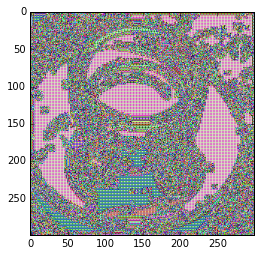

In [163]:
plt.imshow(res2[0])

In [183]:
np.shape(np.rollaxis(res2,0,3))

(299, 299, 1, 3)

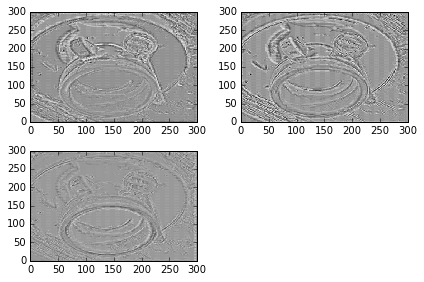

In [184]:
montage_filters(np.rollaxis(res2,0,3))

In [97]:
np.clip?

In [ ]:
# Easier to see if normalize;
# Trying out different forms of normalization to see what is actually going on here

In [156]:
def normalizeFunc(img, s=0.1):
    '''Normalize the image range for visualization'''
    z = img / np.std(img)
    z_std = (z - z.mean()) / max(z.std(), 1e-4) * s + 0.5   # not sure where all these constants came from
    clipped_z = np.clip(z_std,0, 1) * 255
    return np.uint8(clipped_z)

def normalizeFunc1(img, s=0.1):
    '''Normalize the image range for visualization'''
    z = img #/ np.std(img)
    z_std = (z - z.mean()) / max(z.std(), 1e-4) * s + 0.5   # not sure where all these constants came from
    clipped_z = np.clip(z_std,0, 1) * 255
    return np.uint8(clipped_z)

def normalizeFunc2(img, s=0.1):
    '''Normalize the image range for visualization'''
    z = img / np.std(img)
    z_std = (z - z.mean()) #/ max(z.std(), 1e-4) * s + 0.5   # not sure where all these constants came from
    clipped_z = np.clip(z_std,0, 1) * 255
    return np.uint8(clipped_z)

def normalizeFunc3(img, s=0.1):
    '''Normalize the image range for visualization'''
    z = img / np.std(img)
    z_std = (z - z.mean()) / max(z.std(), 1e-4) #* s + 0.5   # not sure where all these constants came from
    clipped_z = np.clip(z_std,0, 1) * 255
    return np.uint8(clipped_z)

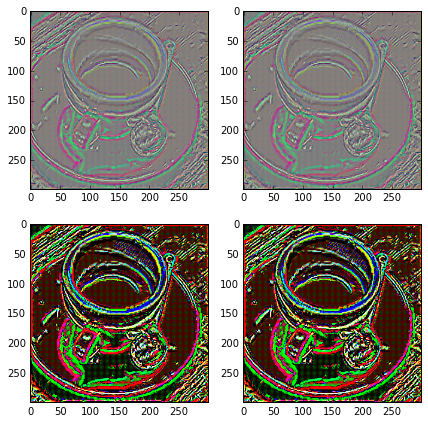

In [164]:
plt.figure(figsize=[7,7])

plt.subplot(2,2,1)
res2_norm = normalizeFunc(res2)
plt.imshow(res2_norm[0])

plt.subplot(2,2,2)
res2_norm1 = normalizeFunc1(res2)
plt.imshow(res2_norm1[0])

plt.subplot(2,2,3)
res2_norm2 = normalizeFunc2(res2)
plt.imshow(res2_norm2[0])

plt.subplot(2,2,4)
res2_norm3 = normalizeFunc3(res2)
plt.imshow(res2_norm3[0])

(1, 299, 299, 3)
(1, 1, 299, 299, 3)
(1, 299, 299, 3)
(1, 1, 299, 299, 3)


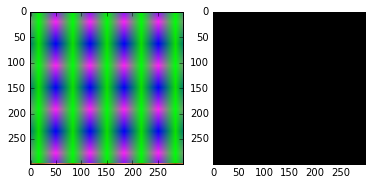

In [193]:
# specify reduce_ind
reduce_max_test = tf.reduce_mean(feature, reduce_ind)
gradient_test = tf.gradients(reduce_max_test, x)
res_test = sess.run(gradient_test, feed_dict={x: img_4d})[0]
print(res_test.shape)
print(np.shape(sess.run(gradient_test, feed_dict={x: img_4d})))

# don't specify reduce_ind
reduce_max_test2 = tf.reduce_mean(feature)
gradient_test2 = tf.gradients(reduce_max_test2, x)
res_test2 = sess.run(gradient_test2, feed_dict={x: img_4d})[0]
print(res_test2.shape)
print(np.shape(sess.run(gradient_test2, feed_dict={x: img_4d})))

plt.subplot(1,2,1)
plt.imshow(res_test[0])
plt.subplot(1,2,2)
plt.imshow(res_test2[0])


# --> I don't get it

In [173]:
# Ok, let's make it easier to look at different activations by writing as functions

# Before had: reduce_ind = 3
# feature = g.get_tensor_by_name('inception/conv2d0_pre_relu:0')
# f = feature.eval(feed_dict={x: img_4d})
# gradient = tf.gradients(tf.reduce_max(feature, reduce_ind), x)
# res2 = sess.run(gradient, feed_dict={x: img_4d})[0]

# if don't specify 'reduce_ind', all dimensions reduced --> get single element



def compute_1gradient(input_placeholder, img, layer_name, neuron_i):
    feature = g.get_tensor_by_name(layer_name)
    gradient = tf.gradients(tf.reduce_mean(feature[:, :, :, neuron_i]), input_placeholder)   
    res = sess.run(gradient, feed_dict={input_placeholder: img})[0]
    return res

def compute_gradients(input_placeholder, img, layer_name):
    feature = g.get_tensor_by_name(layer_name)
    layer_shape = tf.shape(feature).eval(feed_dict={input_placeholder: img})
    gradients = []
    for neuron_i in range(layer_shape[-1]):
        gradients.append(compute_1gradient(input_placeholder, img, layer_name, neuron_i))
    return gradients

(1, 299, 299, 3)


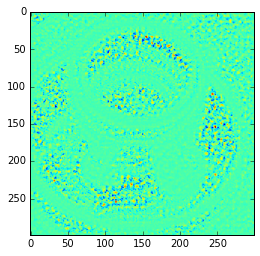

In [174]:
# so, here we're doing something different because we're just getting a single mean 
# (vs. vector of maxes in gradient example above)
# [??] !! Not quite sure what is going on 

res2_func = compute_1gradient(x, img_4d, 'inception/conv2d1_pre_relu:0', 3)
print(res2_func.shape)
plt.imshow(res2_func[0,:,:,1])

In [147]:
gradients_norm = [normalizeFunc(gradient_i[0]) for gradient_i in gradients]
#montage = utils.montage(np.array(gradients_norm))
print(np.shape(gradients_norm))
gradients_norm = np.array(gradients_norm)

gradients_norm_trans = np.rollaxis(gradients_norm,0,4)
print(np.shape(gradients_norm_trans))

#(150, 150, 1, 64)

(64, 299, 299, 3)
(299, 299, 3, 64)


In [149]:
plt.figure(figsize=[20,20])
montage_filters(gradients_norm_trans)

In [150]:
# get all maxpool operations
features_maxpool = [name for name in names if 'maxpool' in name.split('/')[-1]]
print(features_maxpool)

[u'inception/maxpool0', u'inception/maxpool1', u'inception/maxpool4', u'inception/maxpool10']


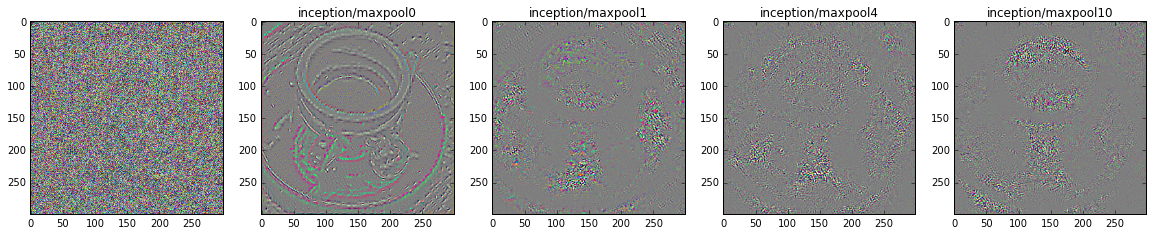

In [198]:
# loop over all maxpool features 

n_plots = len(features_maxpool) + 1
fig, axs = plt.subplots(1, n_plots, figsize=(20, 5))
base = img_4d
axs[0].imshow(img)
for feature_i, featurename in enumerate(features_maxpool):
    feature = g.get_tensor_by_name(featurename + ':0')
    neuron = tf.reduce_max(feature, len(feature.get_shape())-1)
    gradient = tf.gradients(tf.reduce_sum(neuron), x)
    this_res = sess.run(gradient[0], feed_dict={x: base})[0]
    axs[feature_i+1].imshow(normalizeFunc(this_res))
    axs[feature_i+1].set_title(featurename)